# Wordle Explorer

This program helps you explore the 'word space' of Wordle.
If you know the answer, this lets you explore how many possibilities there were for each of your guess.
If you don't know the answer, you can input information about your letters and reduce the search space to get inspiration.

Commands:
- a five letter word you've guessed
- $ - end guessing
- \% - see the frequency of the letters remaining in the search space
- \# - see a random sampling of words remaining in the search space (#10 returns 10, default 5)
- _ - reset the search space
- _* - reset the search space and choose a new, random answer
- . - input information about the puzzle e.g. `.2=R`

The format of the input information command is `<pos><op><letter>`. Pos is the position and letter is the letter (e.g. `0 T` is T and the 1st position.

Available <op>erations are:
- = - The letter is placed in the position
- ? - This letter is not in this position, but is somewhere in the answer
- ! - This letter is not in this position, or anywhere in the answer

In [1]:
from wordlexp import *

guess: audio
aUDiO
39 / 12972 remaining 0.3% - 16
guess: proud
aUDiO
prOUD
14 / 12972 remaining 0.1% - 8
guess: ^14


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
224,COULD,True,C,O,U,L,D,5
2258,HOUND,True,H,O,U,N,D,5
1046,WOULD,True,W,O,U,L,D,5
1701,BOUND,True,B,O,U,N,D,5
583,MOUND,True,M,O,U,N,D,5
285,FOUND,True,F,O,U,N,D,5
863,SOUND,True,S,O,U,N,D,5
1998,WOUND,True,W,O,U,N,D,5


space 14 ( 8 )
guess: %


,count,freq
value,,
N,10,0.714286
L,6,0.428571
M,2,0.142857
S,2,0.142857
W,2,0.142857


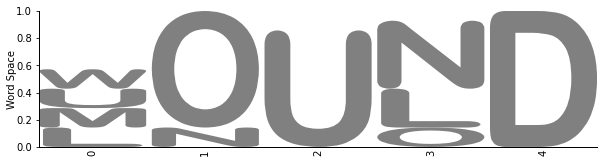

guess: $
Invalid guess


In [2]:
play("could")

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_57706/1333890590.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["{:,}".format(int(_)) for _ in p.get_yticks()])


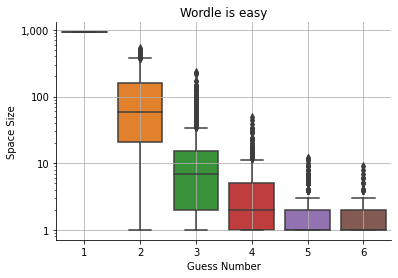

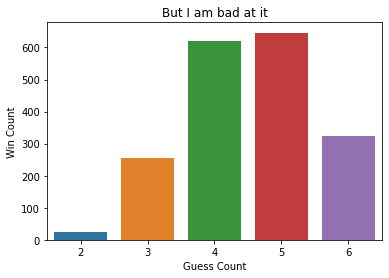

129 6.45%


In [784]:
evaluate_first_word('stomp', 2000)

# New Explorer

All the 'best word' work are frequentists. Most are looking at the letter frequency. Some are looking at the letter's frequency in positions. Few, if any, are looking at the network of words. If we consider the words a network, we should be able to find a 'central' node that best partitions the remaining words (or best eliminates the most possibilities, on average.

I've already shown that random guesses (on hard mode) have patterns of reducing the space. Now, let's see what we can do to find this out.

In [ ]:

# For all of the words,
# I want to see their weight - or how many valid words are left, on average/ median, after
# It is guessed. 
# Therefore, I have to do each work 2k times for each of the valid answers.
# Or I can do them 
lookup = []
for _, guess in all_words.sample(10).iterrows():
    # I need to build for all the possible words
    # How many are still valid after this guess.
    for _, ans in all_words[all_words['valid']].iterrows():
        inside = guess[letter_cols].isin(ans[letter_cols])
        equals = guess[letter_cols] == ans[letter_cols]
        lookup.append(guess, ans, *inside, *equals)    

In [18]:
all_words[all_words['valid']][letter_cols].isin(['A']).sum(axis=1)

0       1
1       0
2       0
3       0
4       2
       ..
2310    0
2311    0
2312    1
2313    1
2314    1
Length: 2315, dtype: int64

In [4]:
#A-Z in word at all - give them all neighbors
header = []
parts = []
for i in range(ord('A'), ord('Z') + 1):
    letter = chr(i)
    header.append(letter)
    has_letter = all_words[all_words['valid']][letter_cols].isin([letter]).sum(axis=1)
    #has_letter['letter'] = letter
    parts.append(has_letter)
data = pd.concat(parts, axis=1)
data.columns = header
#A-Z in a position - give them all edges

#Then I hunt for neighborhoods? Or some kind of way to separate pieces.

In [5]:
data.head()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,1,0,1,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,3,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
from sklearn.decomposition import PCA
n_components = 5
comp_header = ['pc%d' % (_+1) for _ in range(n_components)]
x = PCA(n_components=n_components)
principalComponents = x.fit_transform(data.values)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = comp_header)
principalDf['word'] = all_words[all_words['valid']]['word']#header#

In [8]:
x.explained_variance_ratio_

array([0.10961935, 0.08983781, 0.08020681, 0.07604924, 0.06936269])

In [20]:
from sklearn import cluster
clust = cluster.KMeans(3, random_state=2)
clust.fit(principalDf[['pc1', 'pc2', 'pc3', 'pc4', 'pc5']])
labels = pd.Series(clust.labels_, name="label", index=principalDf.index, dtype=str)
#all_words[all_words['valid']].index

In [21]:
principalDf['label'] = labels

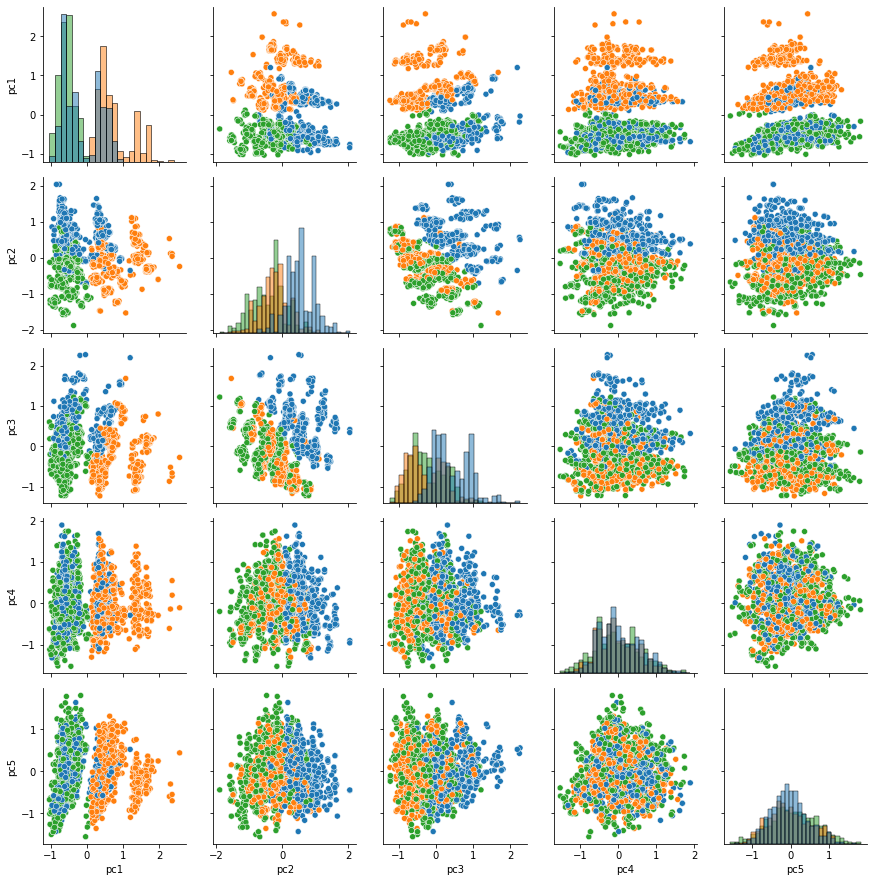

In [22]:
g = sb.PairGrid(data=principalDf, vars=comp_header, hue='label')
g.map_offdiag(sb.scatterplot)#, alpha=0.2)
g.map_diag(sb.histplot)

label 0


,count,freq
value,,
A,850,0.998825
E,344,0.404230
R,313,0.367803
L,276,0.324324
T,238,0.279671


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
495,MARSH,True,M,A,R,S,H,5
1153,ACRID,True,A,C,R,I,D,5
181,PEACH,True,P,E,A,C,H,5
1397,CHAIR,True,C,H,A,I,R,5
1150,DIARY,True,D,I,A,R,Y,5


851 valid words


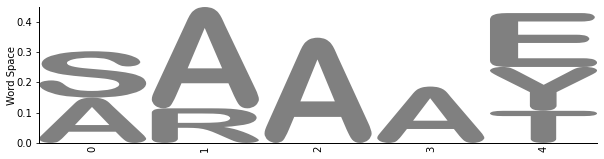

label 1


,count,freq
value,,
O,375,0.494071
I,307,0.404480
U,265,0.349144
T,244,0.321476
R,225,0.296443


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1043,AMONG,True,A,M,O,N,G,5
754,JUICY,True,J,U,I,C,Y,5
1554,ORBIT,True,O,R,B,I,T,5
1893,TALON,True,T,A,L,O,N,5
127,GROWL,True,G,R,O,W,L,5


759 valid words


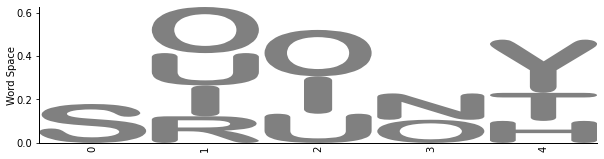

label 2


,count,freq
value,,
E,705,1.000000
R,299,0.424113
I,210,0.297872
O,186,0.263830
T,185,0.262411


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1636,SLEPT,True,S,L,E,P,T,5
900,JOKER,True,J,O,K,E,R,5
1448,MOVER,True,M,O,V,E,R,5
82,BIOME,True,B,I,O,M,E,5
2086,GUISE,True,G,U,I,S,E,5


705 valid words


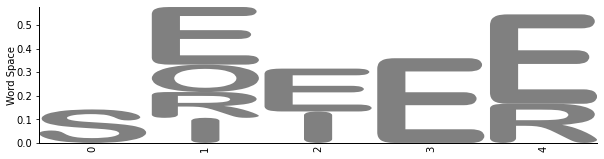

In [30]:
for lab, d in principalDf.groupby(['label']):
    print('label', lab)
    view = all_words[all_words['word'].isin(d['word'])]
    display(letter_summary(view).head())
    display(view[(view['valid']) & (view['unique'] == 5)].sample(5))
    print(len(view['valid']), 'valid words')
    make_logo(view)

In [78]:
power = letter_summary(all_words[all_words['valid'] & (all_words[letter_cols].isin(view['word'])).any(axis=1) ])

In [80]:
power.index

Index(['E', 'T', 'U', 'B', 'D', 'I', 'L', 'M', 'O', 'Q', 'R'], dtype='object', name='value')

In [82]:
all_words[all_words['valid'] & all_words[letter_cols].isin(power.index).any(axis=1)].sample(5)

,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1361,TRUNK,True,T,R,U,N,K,5
2088,TANGO,True,T,A,N,G,O,5
1905,STAVE,True,S,T,A,V,E,5
1136,ROACH,True,R,O,A,C,H,5
501,VALID,True,V,A,L,I,D,5


In [52]:
view = labels.to_frame().join(all_words[all_words["valid"]]['word'])
view[view['label'] == '19']

,label,word
29,19,BATTY
77,19,TOTEM
412,19,TRITE
414,19,TRYST
432,19,PATTY
463,19,TAUNT
573,19,TOTAL
606,19,OCTET
643,19,DITTO
740,19,KITTY


In [54]:
view.sort_values(['label']).to_csv('view', sep='\t', index=False)

In [118]:
valid = all_words[all_words["valid"]]


make_logo(seqlogo)

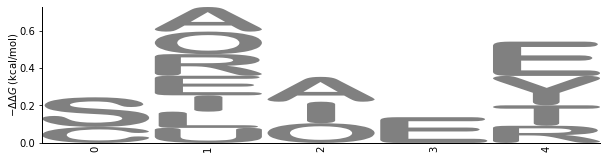

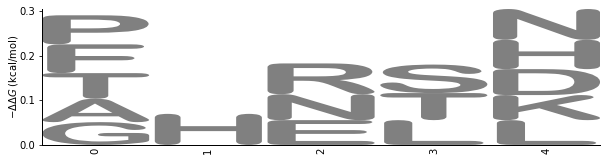

In [142]:
valid = all_words[all_words["valid"] & (all_words["unique"] == 5)]
total = len(valid)
min_freq = 0.05
max_freq = 0.07
rows = []
for i in range(5):
    m_row = valid[f"L-{i}"].value_counts() / total
    m_row = m_row.fillna(0)
    m_row[(m_row < min_freq) | (m_row > max_freq)] = 0
    rows.append(m_row) 
    #all_words[all_words["valid"]][letter_cols].value_counts().reset_index().head()
seqlogo = pd.concat(rows, axis=1).T
seqlogo['pos'] = range(5)
seqlogo.reset_index(drop=True, inplace=True)
seqlogo.set_index('pos', inplace=True)

make_logo(seqlogo)

In [148]:
cands = valid["L-0"].isin(["P", "F", "T", "A", "G"])
#cands = cands | valid["L-1"].isin(["H"])
cands = cands & valid["L-2"].isin(["R", "N", "E"])
cands = cands & valid["L-3"].isin(["S", "T", "L"])
cands = cands & valid["L-4"].isin(["N", "H", "D", "K", "L"])
valid[cands]

,word,valid,L-0,L-1,L-2,L-3,L-4,unique
22,FRESH,True,F,R,E,S,H,5
53,FLESH,True,F,L,E,S,H,5
55,FORTH,True,F,O,R,T,H,5
363,GIRTH,True,G,I,R,T,H,5
391,FIELD,True,F,I,E,L,D,5


[Text(0, 0.5, 'Word Space'), Text(0.5, 1.0, 'Best Initial Guess')]

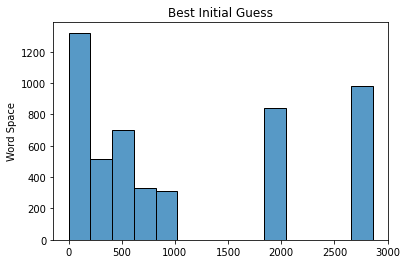

In [159]:
cnts = []
for i in range(5000):
    ans = get_random_word()
    result = make_guess(all_words, 'field', ans)
    c = (result == 0).sum()
    cnts.append(c)
sb.histplot(cnts).set(ylabel="Word Space", title="Best Initial Guess")

In [160]:
cnts = pd.Series(cnts, name="Counts")
cnts.describe()

count    5000.000000
mean     1123.950000
std      1076.024422
min         1.000000
25%       197.000000
50%       513.000000
75%      2006.000000
max      2863.000000
Name: Counts, dtype: float64

In [161]:
play()

guess: field
37 / 12972 remaining 0.3% - 16
guess: @
F I E L D 
guess: stead
9 / 12972 remaining 0.1% - 4
guess: @
F I E L D 
S T E A D 
guess: #


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1334,BREED,True,B,R,E,E,D,4
1971,GREED,True,G,R,E,E,D,4
4816,DREED,False,D,R,E,E,D,3
910,CREED,True,C,R,E,E,D,4
5031,EMEND,False,E,M,E,N,D,4


space 9
guess: #10


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
8666,OGEED,False,O,G,E,E,D,4
1971,GREED,True,G,R,E,E,D,4
910,CREED,True,C,R,E,E,D,4
1770,KNEED,True,K,N,E,E,D,4
1334,BREED,True,B,R,E,E,D,4
12098,UPEND,False,U,P,E,N,D,5
9382,PREED,False,P,R,E,E,D,4
5031,EMEND,False,E,M,E,N,D,4
4816,DREED,False,D,R,E,E,D,3


space 9
guess: %


,count,freq
value,,
R,5,0.555556
N,3,0.333333
G,2,0.222222
P,2,0.222222
B,1,0.111111
C,1,0.111111
K,1,0.111111
M,1,0.111111
O,1,0.111111


guess: GREED
1 / 12972 remaining 0.0% - 1
guess: #


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1770,KNEED,True,K,N,E,E,D,4


space 1
guess: KNEED
1 / 12972 remaining 0.0% - 1
guess: @
F I E L D 
S T E A D 
G R E E D 
K N E E D 
guess: _
guess: field
37 / 12972 remaining 0.3% - 16
guess: @
F I E L D 
guess: kneed
1 / 12972 remaining 0.0% - 1
guess: @
F I E L D 
K N E E D 
guess: _
guess: _
guess: #


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
4628,DIRAM,False,D,I,R,A,M,5
3938,CIMEX,False,C,I,M,E,X,5
2782,ASHES,False,A,S,H,E,S,4
5785,GERLE,False,G,E,R,L,E,4
11551,TEUCH,False,T,E,U,C,H,5


space 12972


KeyboardInterrupt: Interrupted by user

# code

,letter,freq,count
L-0,S,0.031620,366
L-1,A,0.026263,304
L-2,A,0.026523,307
L-3,E,0.027473,318
L-4,E,0.036631,424


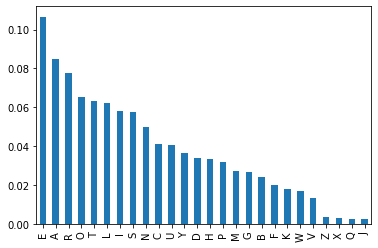

In [1]:


words = pd.read_csv("word_list.txt", header=None)
words.columns = ['word']

words['length'] = words['word'].apply(lambda x: len(str(x)))

words = words[words['length'] == 5]
for i in range(5):
    words[f'L-{i}'] = words['word'].apply(lambda x: str(x)[i].upper())
    uniq_cnt = lambda x: len(list(set(x)))


words['unique'] = words[letter_cols].apply(uniq_cnt, axis=1)

def make_summary(df):
    # Returns the summary, and the overall freq
    counts = []
    for i in range(5):
        counts.append(df[f'L-{i}'].value_counts())

    counts = pd.concat(counts, axis=1)
    pos_freqs = counts / counts.sum().sum() 
    view = pd.concat([pos_freqs.idxmax(), pos_freqs.max()], axis=1)
    view.columns = ['letter', 'freq']
    n_col = []
    for pos, x in enumerate(pos_freqs.idxmax()):
        n_col.append(len(df[df[f"L-{pos}"] == x]))
    view["count"] = n_col
    
    overall_freq = counts.sum(axis=1) / counts.sum().sum()
    overall_freq.sort_values(ascending=False, inplace=True)
    overall_freq.plot(kind='bar')
    
    return view, overall_freq

qsum, overall_freq = make_summary(words)
qsum

1566


,letter,freq,count
L-0,S,0.034100,267
L-1,A,0.025670,201
L-2,A,0.031162,244
L-3,E,0.023627,185
L-4,E,0.039080,306


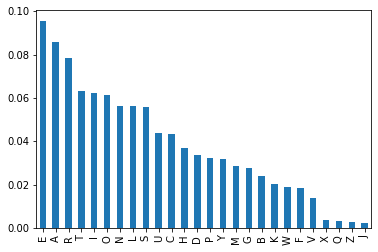

In [2]:
five_distinct_letters = words[words["unique"] == 5]
print(len(five_distinct_letters))
a, b = make_summary(five_distinct_letters)
a

In [3]:
common_fdls = five_distinct_letters[(five_distinct_letters[letter_cols] == ["S", "A", "R", "E", "E"]).any(axis=1)]

In [4]:
common_fdls_count = (five_distinct_letters[letter_cols] == ["S", "A", "R", "E", "E"]).sum(axis=1)

In [5]:
candidates = five_distinct_letters[common_fdls_count == 3]
candidates

,word,length,L-0,L-1,L-2,L-3,L-4,unique
275,saute,5,S,A,U,T,E,5
334,farce,5,F,A,R,C,E,5
579,safer,5,S,A,F,E,R,5
611,carve,5,C,A,R,V,E,5
672,siren,5,S,I,R,E,N,5
849,barge,5,B,A,R,G,E,5
973,harem,5,H,A,R,E,M,5
1048,large,5,L,A,R,G,E,5
1399,shrew,5,S,H,R,E,W,5
1544,screw,5,S,C,R,E,W,5


In [6]:
# Give them a score of the sum of their letter frequency
candidates['score'] = candidates[letter_cols].applymap(lambda x: overall_freq[x]).sum(axis=1)
candidates.sort_values(['score'], ascending=False, inplace=True)
candidates

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_29041/3581157700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['score'] = candidates[letter_cols].applymap(lambda x: overall_freq[x]).sum(axis=1)
/Users/a233287/pve/lib/python3.8/site-packages/pandas-1.3.3-py3.8-macosx-10.15-x86_64.egg/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,word,length,L-0,L-1,L-2,L-3,L-4,unique,score
1607,saner,5,S,A,N,E,R,5,0.376242
1640,parse,5,P,A,R,S,E,5,0.358272
1048,large,5,L,A,R,G,E,5,0.357754
275,saute,5,S,A,U,T,E,5,0.352225
672,siren,5,S,I,R,E,N,5,0.349633
579,safer,5,S,A,F,E,R,5,0.346436
2032,sauce,5,S,A,U,C,E,5,0.330454
334,farce,5,F,A,R,C,E,5,0.329849
973,harem,5,H,A,R,E,M,5,0.329676
1901,salve,5,S,A,L,V,E,5,0.324233


In [7]:
# I think I want to weigh against vowels, so I'm going to give them a 0.75 weight
from collections import defaultdict
weighted_freqs = overall_freq.copy()
for i in ['A', 'E', 'I', 'O', 'U']:
    weighted_freqs[i] = weighted_freqs[i] * 2
candidates['score'] = candidates[letter_cols].applymap(lambda x: weighted_freqs[x]).sum(axis=1)
candidates.sort_values(['score'], ascending=False, inplace=True)
candidates.head(20)

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_29041/1183194652.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['score'] = candidates[letter_cols].applymap(lambda x: weighted_freqs[x]).sum(axis=1)
/Users/a233287/pve/lib/python3.8/site-packages/pandas-1.3.3-py3.8-macosx-10.15-x86_64.egg/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,word,length,L-0,L-1,L-2,L-3,L-4,unique,score
275,saute,5,S,A,U,T,E,5,0.583672
1607,saner,5,S,A,N,E,R,5,0.567343
2032,sauce,5,S,A,U,C,E,5,0.561901
1640,parse,5,P,A,R,S,E,5,0.549374
1048,large,5,L,A,R,G,E,5,0.548855
579,safer,5,S,A,F,E,R,5,0.537538
334,farce,5,F,A,R,C,E,5,0.520950
973,harem,5,H,A,R,E,M,5,0.520778
1901,salve,5,S,A,L,V,E,5,0.515335
611,carve,5,C,A,R,V,E,5,0.514298


In [8]:
overall_freq

E    0.106523
A    0.084579
R    0.077667
O    0.065140
T    0.062981
L    0.062117
I    0.057970
S    0.057797
N    0.049676
C    0.041210
U    0.040346
Y    0.036717
D    0.033952
H    0.033607
P    0.031706
M    0.027300
G    0.026868
B    0.024276
F    0.019870
K    0.018143
W    0.016847
V    0.013218
Z    0.003456
X    0.003197
Q    0.002505
J    0.002333
dtype: float64

In [9]:
five_distinct_letters['vowel_count'] = five_distinct_letters[letter_cols].isin(['A', 'E', "I", "O", "U"]).sum(axis=1)

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_29041/1124756677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_distinct_letters['vowel_count'] = five_distinct_letters[letter_cols].isin(['A', 'E', "I", "O", "U"]).sum(axis=1)


In [10]:
words[words["unique"] == 5].sample(1)

,word,length,L-0,L-1,L-2,L-3,L-4,unique
2223,brown,5,B,R,O,W,N,5


In [4]:
placed_letters = [None, None, "O", None, None]
unplaced_letters = {"N": ['L-2', 'L-3', 'L-4'],
                   "O": ['L-1', 'L-3'],
                   "L": ["L-1"],
                   "K": ["L-4"]}
absent_letters = list('HAGSPITDEMBC')

In [5]:
placed_letters = [None, None, "O", None, None]
unplaced_letters = {"N": ['L-2', 'L-3', 'L-4'],
                   "O": ['L-1', 'L-3'],
                   "L": ["L-1"],
                   "K": ["L-4"]}
absent_letters = list('HAGSPITDEMBC')
view = words.copy()
filt = np.zeros(len(view))
for pos, i in enumerate(placed_letters):
    if i is not None:
        filt += view[f"L-{pos}"] != i

for letter, poss in unplaced_letters.items():
    filt += ~view[letter_cols].isin([letter]).any(axis=1)
    for pos in poss:
        filt += view[pos] == letter
filt += view[letter_cols].isin(absent_letters).any(axis=1)

print((filt == 0).sum(), 'possibilities')

view[filt == 0].sort_values('unique', ascending=False)


1 possibilities


,word,length,L-0,L-1,L-2,L-3,L-4,unique
219,knoll,5,K,N,O,L,L,4


In [56]:
cnt.groupby(['guess'])['space'].describe()

,count,mean,std,min,25%,50%,75%,max
guess,,,,,,,,
1,7500.0,220.170400,237.465955,1.0,42.0,131.0,317.0,1325.0
2,7445.0,19.280457,30.034792,1.0,3.0,8.0,23.0,415.0
3,6450.0,3.337519,4.450974,1.0,1.0,2.0,4.0,63.0
4,3537.0,1.641504,1.425113,1.0,1.0,1.0,2.0,26.0
5,1079.0,1.346617,0.901640,1.0,1.0,1.0,1.0,12.0
6,225.0,1.226667,0.602969,1.0,1.0,1.0,1.0,6.0


No handles with labels found to put in legend.


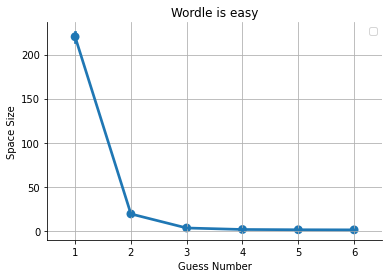

[Text(0.5, 1.0, 'But I am bad at it'),
 Text(0.5, 0, 'Guess Count'),
 Text(0, 0.5, 'Win Count')]

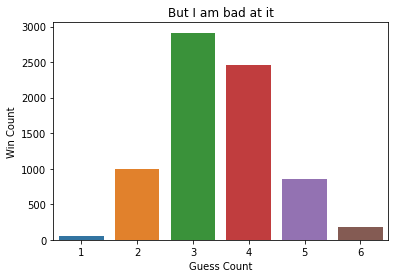

38 0.51%


In [75]:
# Only going to make answers for a sampling of valid words
to_do = all_words[all_words["valid"]].sample(75)['word']
results = []
cnt_all = []
pos = 0
for answer in to_do:
    for i in range(100):
        results = random_guesser(all_words.reset_index(), answer)
        cnt_all.extend(results)
cnt_all = pd.DataFrame(cnt_all, columns=["space", "guess"])

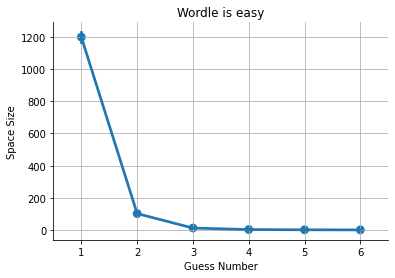

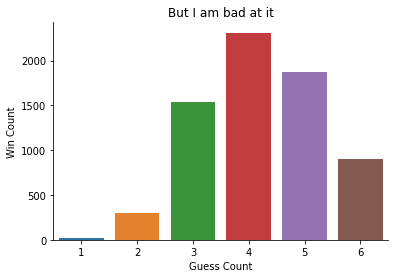

554 7.39%


,count,mean,std,min,25%,50%,75%,max
guess,,,,,,,,
1,7500.0,1197.646667,1353.094757,1.0,206.0,689.5,1750.25,8158.0
2,7484.0,103.192811,171.778187,1.0,11.0,38.0,121.00,2824.0
3,7184.0,13.468402,27.853740,1.0,2.0,5.0,14.00,1305.0
4,5641.0,4.192342,6.907318,1.0,1.0,2.0,4.00,144.0
5,3330.0,2.513213,3.639917,1.0,1.0,1.0,3.00,91.0
6,1461.0,1.988364,2.046180,1.0,1.0,1.0,2.00,22.0


In [78]:
p = sb.pointplot(data=cnt_all, x="guess", y="space", estimator=np.mean, label='mean')
p.set(title="Wordle is easy", xlabel="Guess Number", ylabel="Space Size")
#p.set_yticks([[str(_) + '_' for _ in p.get_yticks()]])
plt.grid(which='major', axis='both')
sb.despine()
plt.show()

summary = cnt_all[cnt_all["space"] == 1].groupby(['guess']).size().to_frame('win count').reset_index()
p = sb.barplot(data=summary, x="guess", y="win count")
p.set(title="But I am bad at it", xlabel="Guess Count", ylabel="Win Count")
sb.despine()
plt.show()

total_losses = len(cnt_all[(cnt_all["space"] != 1) & (cnt_all["guess"] == 6)])
percent_losses = (total_losses / (75 * 100)) * 100
print(total_losses, "%.2f%%" % (percent_losses))

cnt_all.groupby(['guess'])['space'].describe()

0.16975023126734506

In [57]:
filt += get_space(all_words[filt == 0], "BLACK", "WHACK")
(filt == 0).sum() / len(filt)

0.0010792476102374346

In [59]:
all_words[filt == 0]

,index,word,valid,L-0,L-1,L-2,L-3,L-4
221,221,WHACK,True,W,H,A,C,K
634,634,STACK,True,S,T,A,C,K
781,781,TRACK,True,T,R,A,C,K
879,879,SMACK,True,S,M,A,C,K
1446,1446,SHACK,True,S,H,A,C,K
1618,1618,KNACK,True,K,N,A,C,K
1669,1669,WRACK,True,W,R,A,C,K
1883,1883,SNACK,True,S,N,A,C,K
2165,2165,CRACK,True,C,R,A,C,K
3824,1509,CHACK,False,C,H,A,C,K


In [37]:
x = all_words[filt == 0].copy()
y = get_space(x, 'BRNKK', 'TRAWL')
y

38     0.0
113    1.0
Name: L-1, dtype: float64